# Lesson 04: Contextual Word Representations (Transformers)

In previous lessons, we explored static embeddings (Word2Vec, FastText). While powerful, static embeddings have a fundamental limitation: **one word = one vector**.

In this lab, we dive into **Contextual Representations**. These models generate different embeddings for the same word depending on its surrounding context.

**Key Concepts**:
1. **The Polysemy Problem**: Why "bancă" (money) and "bancă" (bench) should have different vectors.
2. **Transformers Architectures**: The shift from recurrence to self-attention.
3. **BERT & DistilBERT**: Bidirectional representations and model distillation.
4. **Feature Extraction**: Using pre-trained models safely on CPU.
5. **Visualizing Semantic Clusters**: Seeing how context creates distinct semantic regions.

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import umap
from adjustText import adjust_text
import re
from pathlib import Path
import requests

# Add the parent directory to path for imports
# Standard way in this repo: assumes CWD is the notebooks/ directory
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent.parent))

from notebook_utils import path_resolver
from utils import get_improved_stopwords

# Set aesthetic style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)

# Check for device (favoring CPU as per lab instructions)
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. The Limitation of Static Embeddings

Let's revisit "Distributional Semantics": *You shall know a word by the company it keeps*.
Static models (Word2Vec) average out all "companies" a word has ever kept into a single vector.

### 1.1 The Polysemy Problem
Consider these Romanian sentences:
1. "Am scos bani de la **bancă**." (I took money from the bank.)
2. "M-am așezat pe o **bancă** în parc." (I sat on a bench in the park.)

In a static model, the word **bancă** has the same vector in both cases. A contextual model will produce two different vectors.

## 2. Transformers & BERT

### 2.1 Self-Attention
The core innovation of the Transformer (Vaswani et al., 2017) is the **Self-Attention** mechanism. Instead of processing tokens one by one (like RNNs), it allows every token to "look" at every other token in the sentence to weigh their importance.

### 2.2 BERT (Bidirectional Encoder Representations from Transformers)
BERT uses the Transformer Encoder to learn deep bidirectional representations. It is trained on two tasks:
- **Masked LM (MLM)**: Predicting missing words in a sentence.
- **Next Sentence Prediction (NSP)**: Predicting if sentence B follows sentence A.

### 2.3 DistilBERT
DistilBERT is a smaller, faster, cheaper version of BERT. It uses **Knowledge Distillation** to reach ~97% of BERT's performance while being 40% smaller and 60% faster.

We will use `racai/distilbert-base-romanian-cased`, specifically trained for the Romanian language.

In [ ]:
MODEL_NAME = "racai/distilbert-base-romanian-cased"

print(f"Loading tokenizer and model: {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval() # Set to evaluation mode
print("Model loaded successfully.")

Loading tokenizer and model: racai/distilbert-base-romanian-cased...
Model loaded successfully.


## 3. Practical: Extracting Contextual Embeddings

Unlike Word2Vec, where we just look up a key, for BERT we must:
1. **Tokenize** the text (BERT uses WordPiece tokenization).
2. **Pass** the tokens through the model.
3. **Extract** the hidden states (vectors) from the last layer.

Let's define a helper function to get the embedding of a specific word *within* a sentence.

In [ ]:
def get_word_embedding(sentence, target_word, model, tokenizer):
    """
    Extracts the embedding of a target word from a sentence using DistilBERT.
    Handles subwords by averaging their embeddings.
    """
    # Tokenize and get tensor
    inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=True).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the last hidden state: [batch_size, seq_len, hidden_size]
    # DistilBERT hidden size is 768
    last_hidden_states = outputs.last_hidden_state[0]
    
    # Map tokens back to word pieces
    input_ids = inputs['input_ids'][0]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    # Find indices of subwords belonging to the target_word
    # This is a robust way using tokenizer's offset_mapping
    inputs_with_offsets = tokenizer(sentence, return_offsets_mapping=True, add_special_tokens=True)
    offsets = inputs_with_offsets['offset_mapping']
    
    # Find character span of target_word in sentence
    match = re.search(r'\b' + re.escape(target_word) + r'\b', sentence, re.IGNORECASE)
    if not match:
        return None
    
    start_char, end_char = match.start(), match.end()
    
    target_indices = []
    for i, (s, e) in enumerate(offsets):
        # If token overlaps significantly with the target word character span
        if s >= start_char and e <= end_char and s != e:
            target_indices.append(i)
            
    if not target_indices:
        return None
        
    # Average the embeddings of the subwords
    word_embedding = last_hidden_states[target_indices].mean(dim=0)
    return word_embedding.cpu().numpy()

### 4.1 Proving the Difference: "Bancă" vs "Bancă"

Let's compare the vectors for the same word in two very different contexts.

**Wait, why is the similarity so high?**
You might notice values around **0.80**. In static embeddings, a similarity of 0.8 is extremely high. 
However, contextual models often have high "cosine anisotropy" - the vectors occupy a narrow cone in space. 
The **relative** difference is what matters: a jump from 0.8 to 0.9 is a huge semantic shift!

In [ ]:
sent1 = "Am scos toate economiile de la acea bancă centrală."
sent2 = "Am citit o carte stând pe o bancă de lemn în parc."

vec1 = get_word_embedding(sent1, "bancă", model, tokenizer)
vec2 = get_word_embedding(sent2, "bancă", model, tokenizer)

from sklearn.metrics.pairwise import cosine_similarity

if vec1 is not None and vec2 is not None:
    sim = cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]
    print(f"Cosine similarity between 'bancă' (finance) and 'bancă' (bench): {sim:.4f}")
    
    # Contrast with same-meaning context
    sent3 = "Mi-am deschis un cont nou la o altă bancă."
    vec3 = get_word_embedding(sent3, "bancă", model, tokenizer)
    sim_same = cosine_similarity(vec1.reshape(1, -1), vec3.reshape(1, -1))[0][0]
    print(f"Cosine similarity between 'bancă' (finance 1) and 'bancă' (finance 2): {sim_same:.4f}")
    
    print(f"\nObservation: Same-meaning similarity ({sim_same:.4f}) is noticeably higher than multi-meaning similarity ({sim:.4f}).")
else:
    print("Could not find targets in sentences.")

Cosine similarity between 'bancă' (finance) and 'bancă' (bench): 0.7987
Cosine similarity between 'bancă' (finance 1) and 'bancă' (finance 2): 0.8972

Observation: Same-meaning similarity (0.8972) is noticeably higher than multi-meaning similarity (0.7987).


## 5. Contextual Insights from ANPC Dataset

Now let's apply this to our data. We want to see how terms change meaning based on context.

We'll extract a few examples of "control" and "produs" and see if they cluster by context.

In [ ]:
# Load data - Using established relative paths
DATA_FILE = Path("../02_data_preprocessing/data/processed/articles_anpc_preprocessed.json")

df = pd.read_json(path_resolver(DATA_FILE, external=True))

# Filter for relevant articles to get diverse contexts
# 'control' is frequent enough if we look closely
df_energy = df[df['content'].str.contains("energie|electric", case=False, regex=True)].head(30)
df_food = df[df['content'].str.contains("alimentar|produs", case=False, regex=True)].head(30)
df_banking = df[df['content'].str.contains("bancar|credit|financial", case=False, regex=True)].head(30)

target_word = "control"
embeddings = []
labels = []
contexts = []

print(f"Extracting contextual embeddings for '{target_word}'...")

def collect_embeddings(dataframe, category, target):
    count = 0
    # Search for target word specifically
    for _, row in dataframe.iterrows():
        content = row['content'].replace("\n", " ").replace("\r", " ")
        # Better sentence split (handles multiple spaces)
        sentences = re.split(r'(?<=[.!?])\s+', content)
        
        for s in sentences:
            s = s.strip()
            # Look for exact word or variations if needed, but let's stick to 'control'
            if re.search(r'\b' + re.escape(target) + r'\b', s, re.IGNORECASE) and 15 < len(s) < 350:
                vec = get_word_embedding(s, target, model, tokenizer)
                if vec is not None:
                    embeddings.append(vec)
                    labels.append(category)
                    contexts.append(s)
                    count += 1
                    # We can take more than one per article if they are different sentences
                    if count >= 10: break
        if count >= 10: break

print("Gathering samples...")
collect_embeddings(df_energy, "Energie", target_word)
collect_embeddings(df_food, "Alimentar", target_word)
collect_embeddings(df_banking, "Bancar", target_word)

print(f"Extracted {len(embeddings)} embeddings total.")

Extracting contextual embeddings for 'control'...
Gathering samples...
Extracted 27 embeddings total.


## 6. Visualization: Contextual Clusters

Does "control" in a banking context (account fees, credit transparency) differ from "control" in food safety (expiration dates, hygiene)? 
By extracting embeddings from real ANPC articles, we can visualize these distinct "semantic regions".

/home/marius/ore/inlp/gh/inlp/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


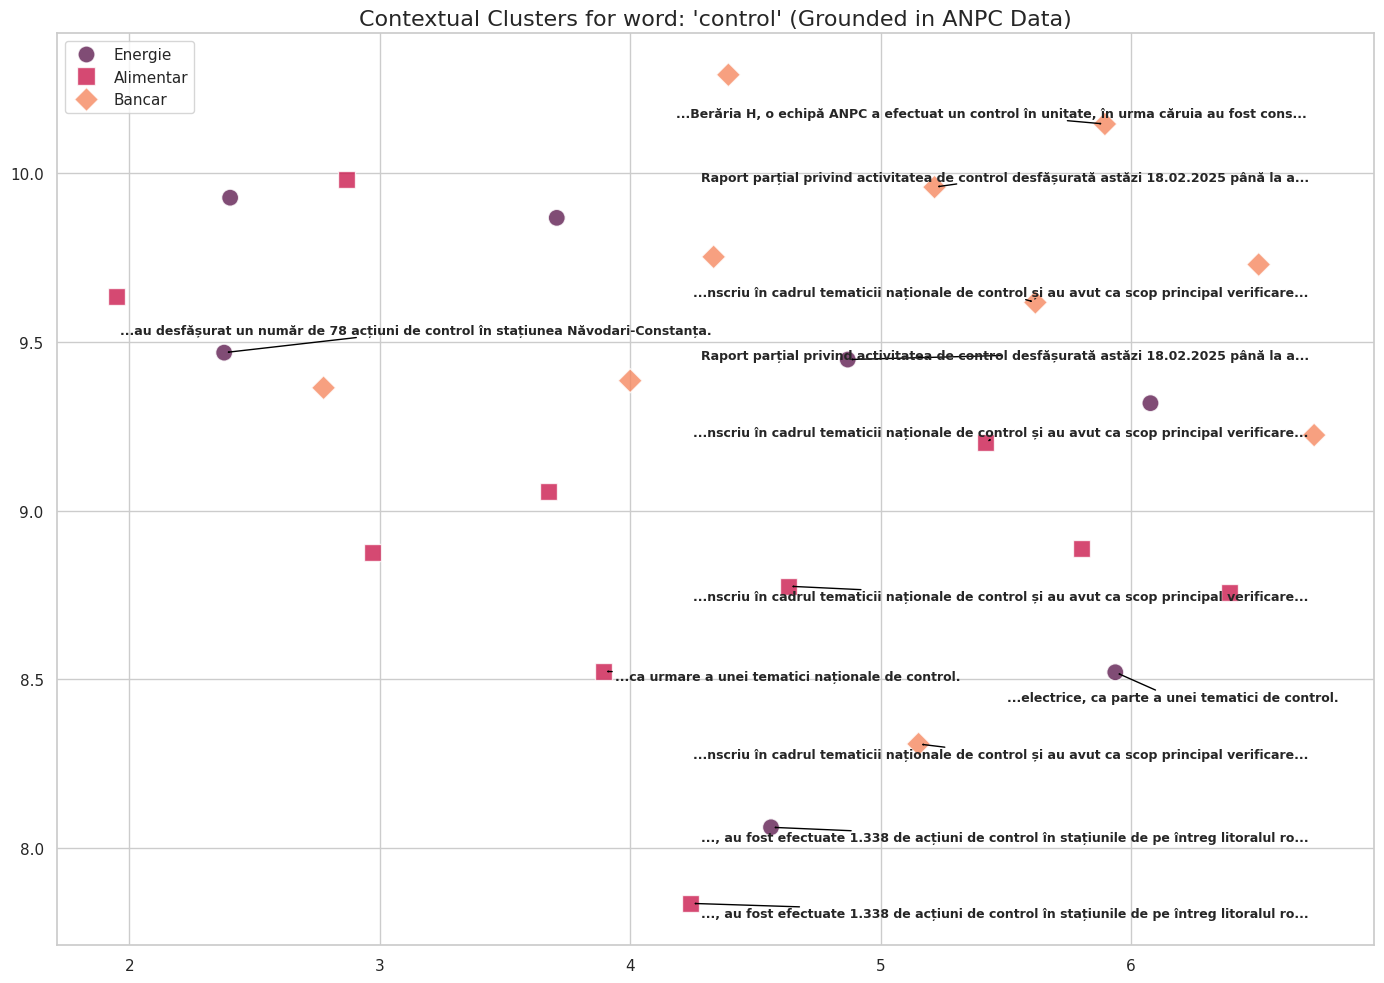

In [ ]:
if len(embeddings) > 10:
    # Use UMAP for dimensionality reduction
    # With fewer points, n_neighbors should be small
    reducer = umap.UMAP(n_neighbors=min(10, len(embeddings)-1), min_dist=0.1, n_components=2, random_state=42)
    umap_results = reducer.fit_transform(np.array(embeddings))

    plt.figure(figsize=(14, 10))
    # Use different markers for better separation visibility
    markers = {"Energie": "o", "Alimentar": "s", "Bancar": "D"}
    
    scatter = sns.scatterplot(
        x=umap_results[:, 0], 
        y=umap_results[:, 1], 
        hue=labels, 
        style=labels,
        markers=markers,
        s=150,
        palette="rocket",
        alpha=0.8
    )

    # Annotate a subset of points to show actual context difference
    texts = []
    # Take 4 from each label to annotate for better visibility
    annotated_indices = []
    for label in sorted(list(set(labels))):
        indices = [i for i, l in enumerate(labels) if l == label]
        annotated_indices.extend(indices[:4])

    for i in annotated_indices:
        # Find target word in context for centering
        context = contexts[i]
        match = re.search(r'\b' + re.escape(target_word) + r'\b', context, re.IGNORECASE)
        if match:
            start, end = match.start(), match.end()
            # Take ~40 chars before and after for better context
            pad = 40
            label_start = max(0, start - pad)
            label_end = min(len(context), end + pad)
            prefix = "..." if label_start > 0 else ""
            suffix = "..." if label_end < len(context) else ""
            short_context = f"{prefix}{context[label_start:label_end].strip()}{suffix}"
        else:
            short_context = context[:60] + "..."
            
        texts.append(plt.text(umap_results[i, 0], umap_results[i, 1], short_context, fontsize=9, fontweight='bold'))

    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=1))
    plt.title(f"Contextual Clusters for word: '{target_word}' (Grounded in ANPC Data)", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough embeddings to visualize.")

## 7. Distributional Semantics in Context

In static models, "neighbors" are fixed. In contextual models, the "neighbors" of a word depend on the sentence.

**Thought Experiment**:
- Sentence A: "Am cumpărat un **produs** proaspăt de la piață."
- Sentence B: "Am configurat un **produs** de creditare la bancă."

If we had a larger corpus to compare against, "produs" in A would be closer to "legume", while in B it would be closer to "dobândă".

## 8. Search & Reranking with Text Embeddings Inference (TEI)

So far, we've used DistilBERT locally on CPU. In production, we often use optimized inference servers. 
**Text Embeddings Inference (TEI)** by Hugging Face is a high-performance toolkit for deploying and serving sequence-to-vector and reranking models (assuming it does not randomly crash).

### 8.1 Why Reranking?
In many search systems (RAG - Retrieval Augmented Generation), we use a cheap model (like BM25) to find 100 candidate documents, and then use a "cross-encoder" or a powerful reranker to re-order those 100 documents more accurately.

### 8.2 Podman/Docker Command for ModernBERT
To run TEI with the ModernBERT reranker model (optimized for efficiency):

```bash
# Run this in your terminal to start the TEI server
podman run -it --platform linux/amd64 -p 8080:80 \
  -e RUST_BACKTRACE=full \
  -v $PWD/data:/data \
  ghcr.io/huggingface/text-embeddings-inference:cpu-1.8 \
  --model-id Alibaba-NLP/gte-reranker-modernbert-base \
  --dtype=float16 --max-batch-tokens 2048 --auto-truncate --max-concurrent-requests 5
```

In [ ]:
TEI_URL = "http://localhost:8080/rerank"

def rerank_documents(query, documents, url=TEI_URL):
    """Query the TEI Rerank API."""
    payload = {
        "query": query,
        "texts": documents,
        "truncate": True
    }
    try:
        response = requests.post(url, json=payload, timeout=50)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"TEI Server not reachable at {url}. (Make sure the docker container is running!)")
        return None

### 8.3 Grounded Experiment: Search for "produse financiare"

Let's take some snippets from our ANPC dataset and see how a reranker helps find the most relevant one.

In [ ]:
# Query
query = "nereguli la contractele de credit bancar"

# Sample documents from different sectors
samples = [
    "Am controlat un magazin alimentar unde am găsit produse expirate.", # Irrelevant
    "Comisarii au verificat modul de calcul al dobânzilor la creditele în franci elvețieni.", # Highly Relevant
    "O benzinărie a fost amendată pentru afișarea incorectă a prețului la motorină.", # Irrelevant
    "Banca a fost sancționată pentru clauze abuzive în contractele de ipotecă.", # Highly Relevant
    "Controlul a vizat etichetarea corectă a produselor din carne de porc." # Irrelevant
]

print(f"Query: {query}\n")
results = rerank_documents(query, samples)

if results:
    # results is a list of objects like {"index": 0, "score": 0.99}
    # Sort by score descending
    sorted_results = sorted(results, key=lambda x: x['score'], reverse=True)
    
    for res in sorted_results:
        idx = res['index']
        score = res['score']
        print(f"[{score:.4f}] {samples[idx]}")

Query: nereguli la contractele de credit bancar

[0.8352] Banca a fost sancționată pentru clauze abuzive în contractele de ipotecă.
[0.7744] Comisarii au verificat modul de calcul al dobânzilor la creditele în franci elvețieni.
[0.7056] O benzinărie a fost amendată pentru afișarea incorectă a prețului la motorină.
[0.7018] Controlul a vizat etichetarea corectă a produselor din carne de porc.
[0.6891] Am controlat un magazin alimentar unde am găsit produse expirate.


---
## Exercises

### Exercise 1: Subtle Semantic Shifts
Find another word in the ANPC dataset that might change meaning depending on the sector (e.g., "tariful", "normă", "viciu"). Extract embeddings for it and visualize if there's a clear separation.

### Exercise 2: Layer Analysis (Bonus)
DistilBERT has 6 layers. We used the *last* layer. Research: which layers are typically better for syntactic tasks vs. semantic tasks? Try extracting from the 3rd layer instead of the 6th and compare the cosine similarity for the "bancă" polysemy.

### Exercise 3: Stopwords in Context
Unlike BoW models, BERT *needs* stopwords to understand context. What happens to the embedding of "bancă" if you remove all surrounding stopwords before passing it to the model? Try it and observe the shift.

### Exercise 4: TEI Reranking Power
Try the reranker with a query about "energie" and see if it correctly ranks energy-related articles above food safety ones. Use excerpts found in Section 5.